In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install darts
!pip install mlforecast
!pip install statsforecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import seaborn as sea

In [3]:
data = pd.read_csv('Processed_Data(Interpolated)')
data.set_index('Date')

,County,median_price,avg_value,CPI,adj_median_price,adj_avg_value
Date,,,,,,
2008-02-02,Los Angeles,450000.000000,415114.267851,212.713241,211552.415394,195152.057841
2008-02-09,Los Angeles,460000.000000,415114.267851,212.896931,216066.994374,194983.678644
2008-02-16,Los Angeles,474000.000000,415114.267851,213.080621,222451.013361,194815.589756
2008-02-23,Los Angeles,482000.000000,415114.267851,213.264310,226010.624666,194647.790425
2008-03-01,Los Angeles,460000.000000,409234.159417,213.448000,215509.163824,191725.459792
...,...,...,...,...,...,...
2024-01-06,Merced,701285.714286,289806.009213,309.905806,226289.956395,93514.223735
2024-01-13,Merced,720142.857143,289806.009213,310.214935,232143.193241,93421.036857
2024-01-20,Merced,696377.142857,289806.009213,310.524065,224258.671850,93328.035515


In [22]:
Counties_median = data[['Date','County','adj_median_price']]
Counties_value = data[['Date','County','adj_avg_value']]

In [23]:
median_train = Counties_median[Counties_median['Date'] < '2023-01-06']
median_test = Counties_median[Counties_median['Date'] >= '2023-01-06']

median_train = median_train.pivot_table(index='Date',columns='County',values='adj_median_price')
median_test = median_test.pivot_table(index='Date',columns='County',values='adj_median_price')

value_train = Counties_value[Counties_median['Date'] < '2023-01-06']
value_test = Counties_value[Counties_median['Date'] >= '2023-01-06']

value_train = value_train.pivot_table(index='Date',columns='County',values='adj_avg_value')
value_test = value_test.pivot_table(index='Date',columns='County',values='adj_avg_value')

CPI = data[['Date','CPI']]
CPI = CPI[CPI['Date'] < '2023-01-06']
CPI = CPI.pivot_table(index='Date',values='CPI')


In [24]:
CPI

,CPI
Date,
2008-02-02,212.713241
2008-02-09,212.896931
2008-02-16,213.080621
2008-02-23,213.264310
2008-03-01,213.448000
...,...
2022-12-03,298.911613
2022-12-10,299.260258
2022-12-17,299.608903


In [25]:
from darts import TimeSeries

median_train = median_train.reset_index()
median_train = TimeSeries.from_dataframe(median_train, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento', 
              'San Diego', 'San Francisco', 'San Luis Obispo'])

median_test = median_test.reset_index()
median_test = TimeSeries.from_dataframe(median_test, time_col='Date', value_cols = ['Fresno', 'Los Angeles', 'Merced', 'Riverside', 'Sacramento',
       'San Diego', 'San Francisco', 'San Luis Obispo'])

CPI = CPI.reset_index()
CPI = TimeSeries.from_dataframe(CPI, time_col='Date',value_cols='CPI')

There is seasonality of order 2.
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 12.
There is seasonality of order 15.
There is seasonality of order 17.
There is seasonality of order 19.
There is seasonality of order 32.
There is seasonality of order 34.
There is seasonality of order 45.
There is seasonality of order 51.
There is seasonality of order 53.
There is seasonality of order 60.
There is seasonality of order 62.
There is seasonality of order 65.
There is seasonality of order 67.
There is seasonality of order 72.
There is seasonality of order 74.
There is seasonality of order 79.
There is seasonality of order 81.
There is seasonality of order 84.
There is seasonality of order 86.
There is seasonality of order 90.
There is seasonality of order 93.
There is seasonality of order 97.
There is seasonality of order 99.
There is seasonality of order 101.
There is seasonality of order 103.


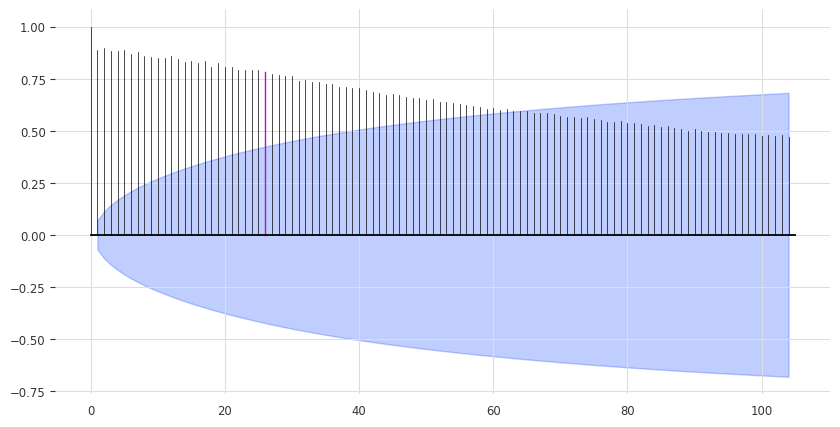

In [99]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(median_train['San Luis Obispo'],m=26,alpha=0.05,max_lag=104)
for m in range(2, 104):
    is_seasonal, period = check_seasonality(median_train['San Luis Obispo'], m=m, alpha=0.05,max_lag=104)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

<Axes: xlabel='Date'>

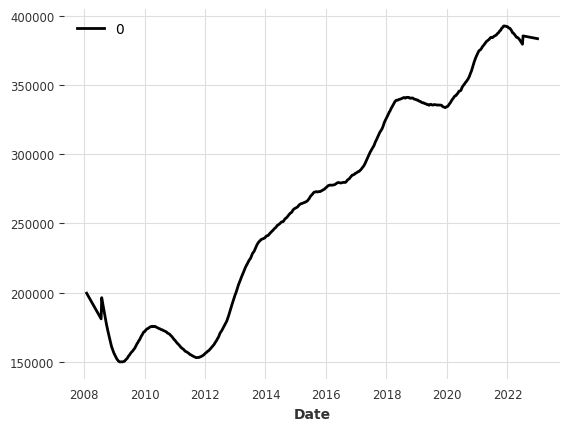

In [130]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

extract_trend_and_seasonality(median_train['San Francisco'],model= ModelMode.MULTIPLICATIVE)[0].plot()

<Axes: xlabel='Date'>

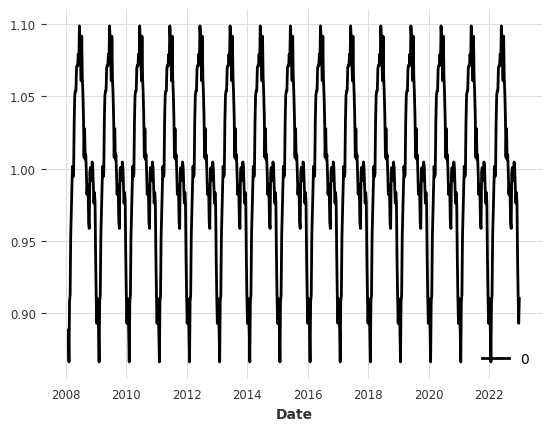

In [131]:
extract_trend_and_seasonality(median_train['San Francisco'],model= ModelMode.MULTIPLICATIVE)[1].plot()

In [ ]:
from darts.models import RegressionModel, RegressionEnsembleModel, NaiveSeasonal
from sklearn.linear_model import BayesianRidge


model = RegressionModel(lags=52,model=BayesianRidge())

model.fit(median_train['Los Angeles'])

preds = model.predict(series = median_train['Los Angeles'],n=52)



c:\Users\alebe\miniforge3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='Date'>

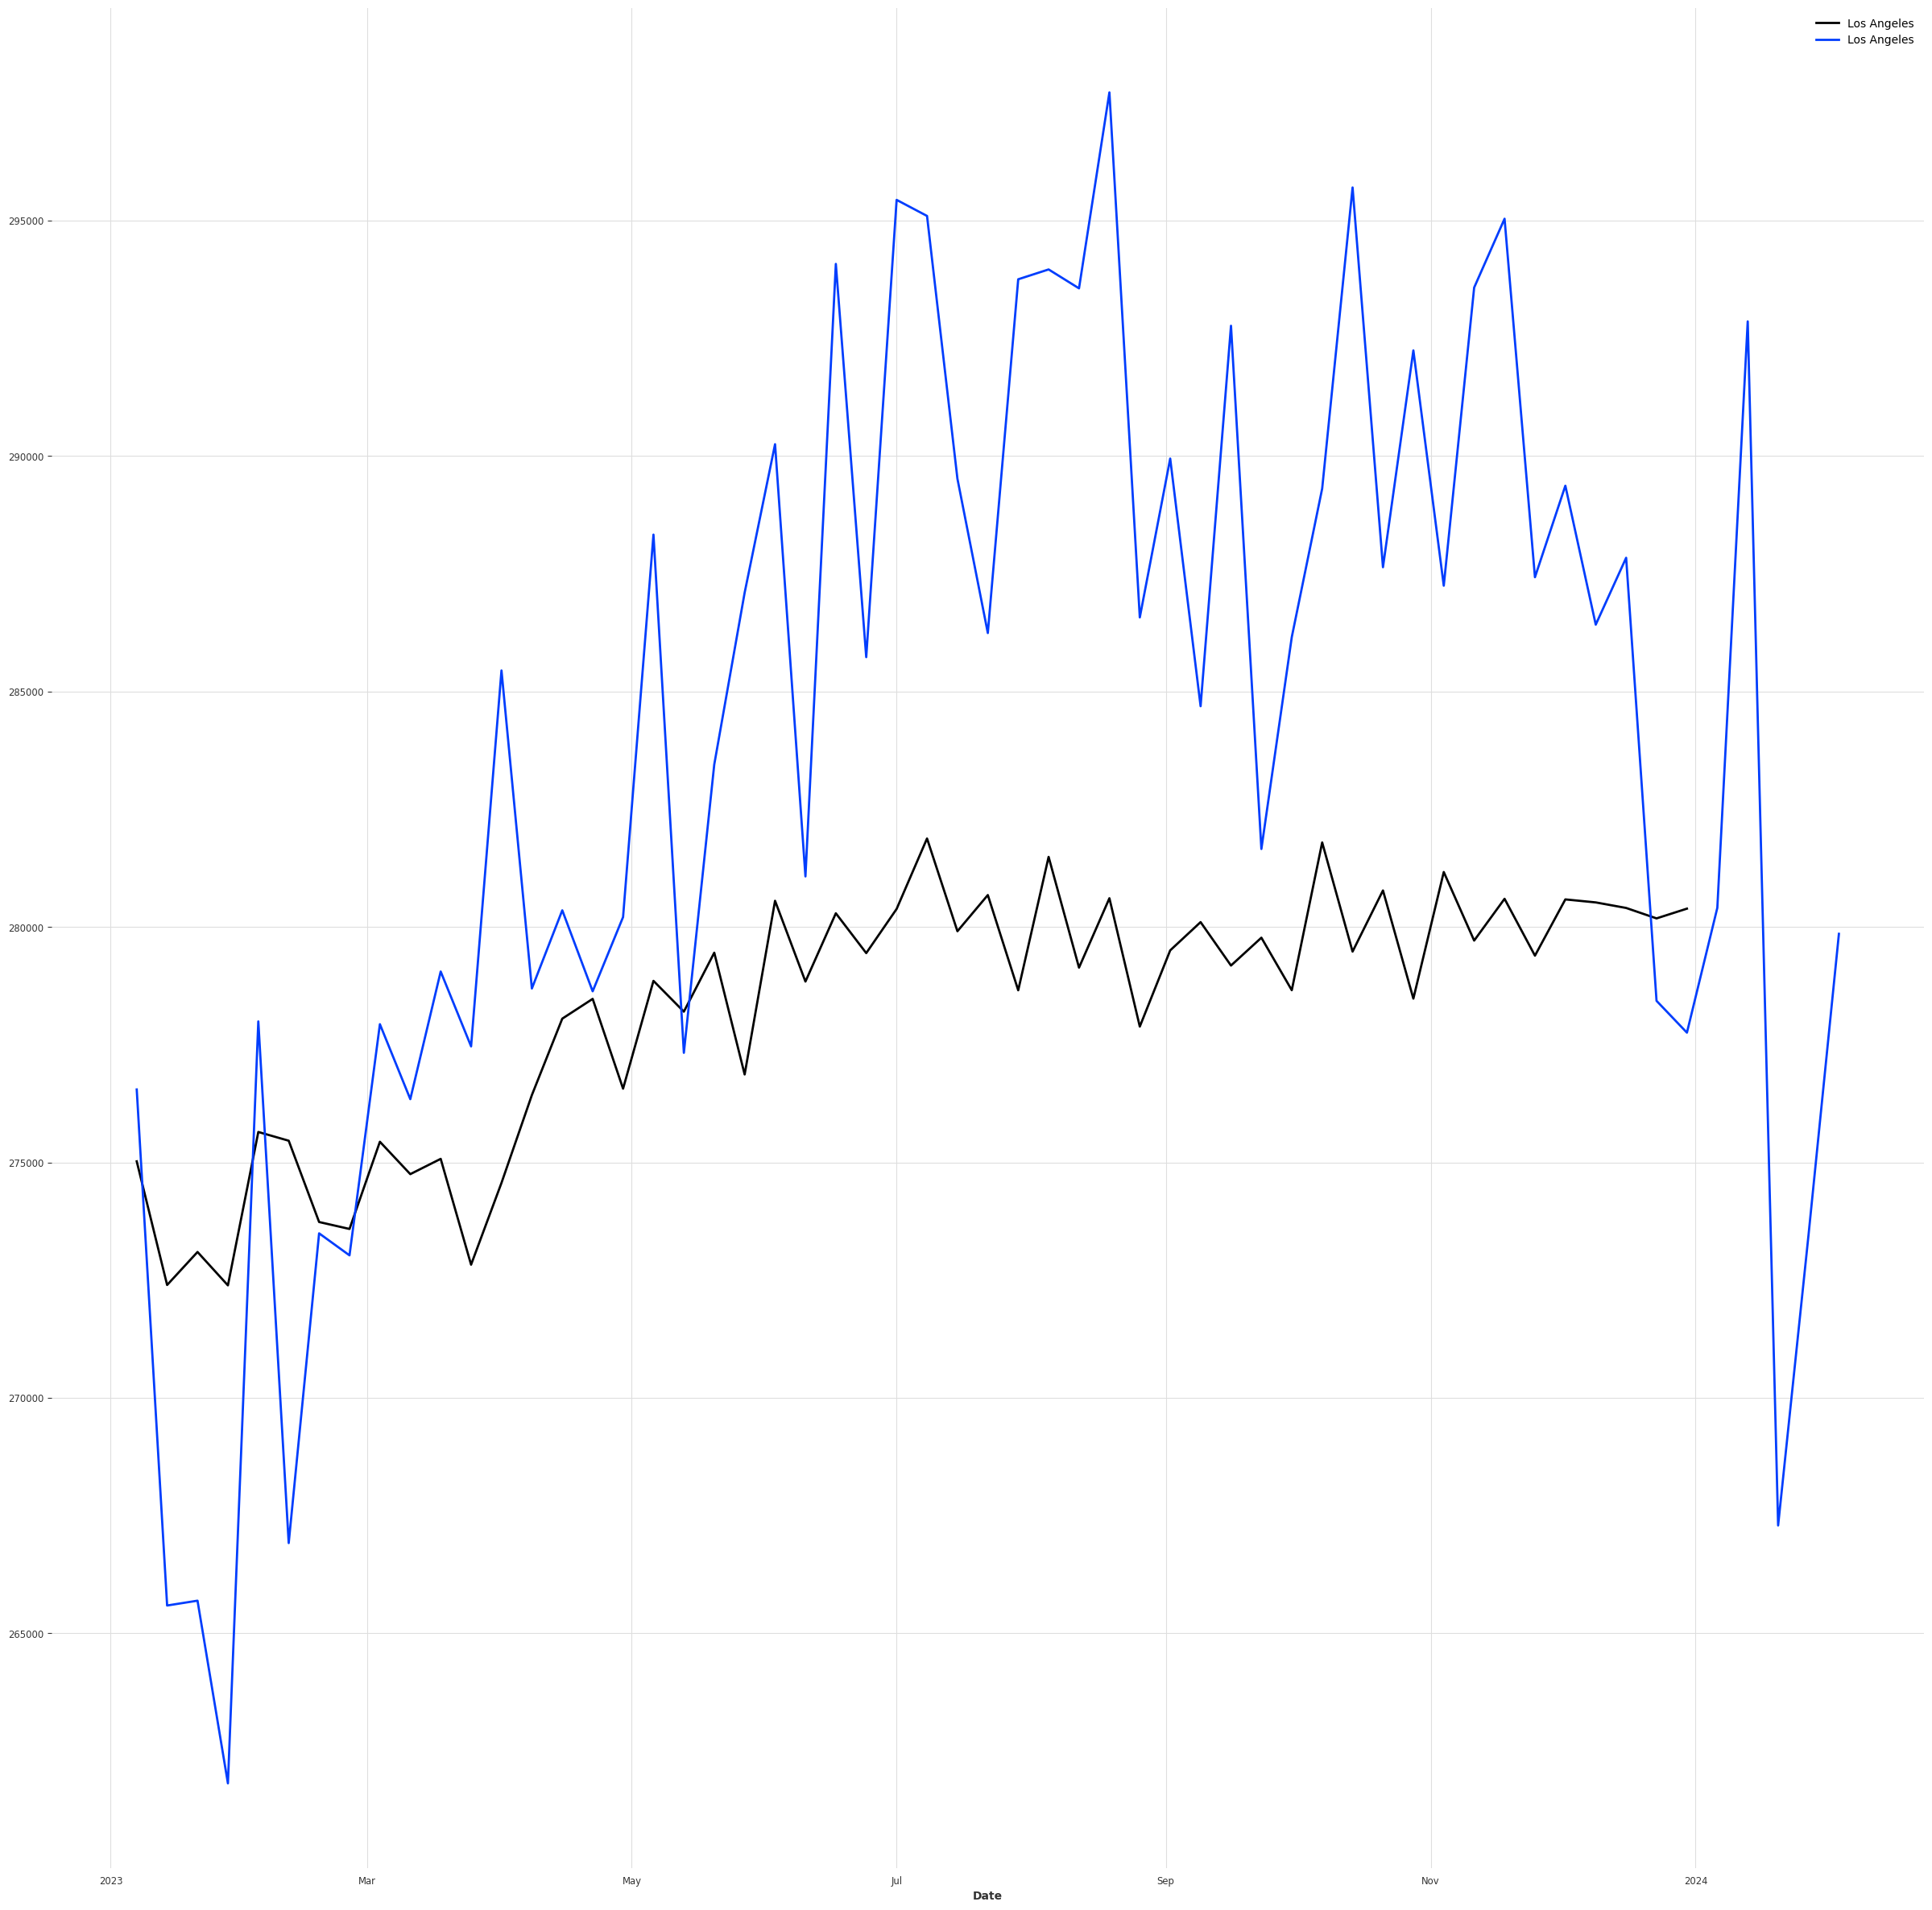

In [ ]:
plt.figure(figsize=(30,30))
preds.plot()
median_test['Los Angeles'].plot()

<Axes: xlabel='Date'>

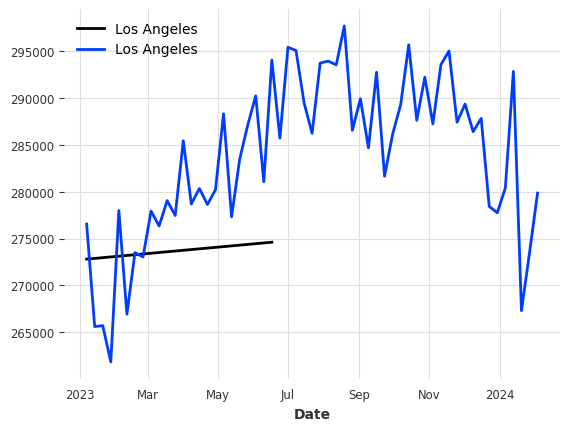

In [123]:
from darts.models import NaiveDrift

model3 = NaiveDrift()

model3.fit(median_train['Los Angeles'])

preds2 = model3.predict(24)

preds2.plot()
median_test['Los Angeles'].plot()

<Axes: xlabel='Date'>

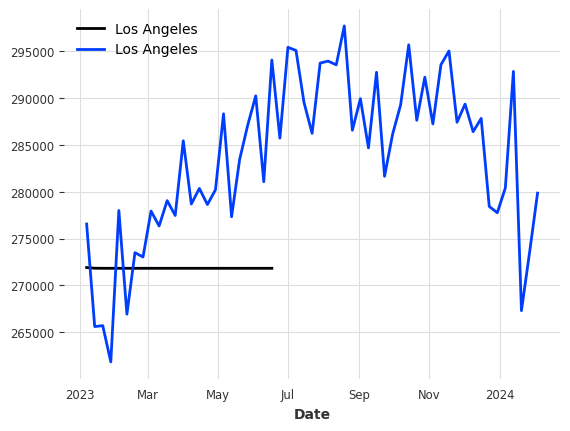

In [125]:
from darts.models import ARIMA

model2 = ARIMA(p=1,d=1,q=1)

model2.fit(median_train['Los Angeles'])

preds = model2.predict(24)
preds.plot()
median_test['Los Angeles'].plot()

In [102]:
from darts

c:\Users\alebe\miniforge3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alebe\miniforge3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(p=12, d=1, q=2, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)